<a href="https://colab.research.google.com/github/AdamChoong0095/NUS-Stock-Data/blob/Adam/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price CS3244 ARIMA section
The goals of this project are:
* To determine an effective model with justificaiton for predicting stock prices of the S&P500
* To determine if the S&P500 is a good indicator of performance for other companies contained in the top 500 performing companies

In [24]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Processing
For every stock or ETF being analysed, we chose to create a continuous data frame by choosing to include the average of the daily high and low as the constant day to day price between opening and closing. We made this decision because of the appropriate statisical representation the mean has of the high and low prices every day.

In [25]:
import pandas as pd
#here is a demonstration of preprocessing done on the S&P500 ETF
sp500=pd.read_csv('/content/drive/MyDrive/cs3244_data/ETFs/spy.us.txt')
sp500.drop(columns={'OpenInt','Volume'}, inplace=True)

In [26]:
sp500

,Date,Open,High,Low,Close
0,2005-02-25,104.77,106.00,104.68,105.79
1,2005-02-28,105.55,105.68,104.56,105.08
2,2005-03-01,105.22,105.87,105.22,105.62
3,2005-03-02,105.21,106.22,105.10,105.57
4,2005-03-03,105.99,106.20,105.15,105.61
...,...,...,...,...,...
3196,2017-11-06,258.30,259.00,258.22,258.85
3197,2017-11-07,258.97,259.35,258.11,258.67
3198,2017-11-08,258.47,259.22,258.15,259.11
3199,2017-11-09,257.73,258.39,256.36,258.17


## Method
To achieve the first goal, we will tune hyperparameters of different models to achieve the best performance possible for each type of model (based on multiple metrics)
* Split data into 80/20 proportion (4 years of training to predict 1 year of prices) to mitigate the effect of overfitting or underfitting. For training/validation, we try cross validation on time series (recommended but more computationally expensive, see code below)
* Select models appropriate for the time series context.
* Compare between model types and ascertain the best model for predicting prices based on a standardised set of metrics.
* Apply the selected model to an assortment of companies contained in the S&P500.
* The purpose of doing this will be to demonstrate whether or not this approach of model selection generalises well on stock price prediction.

The reasoning behind this approach is that the S&P500 is a traditional indicator (by definition) of the performance of the 500 most dominant stocks in Wall Street.

#### Model selection process
The main process applied particularly to the models designated for handling time series data such as ARIMA and ARCH during selection will be as follows:
* Cross validate the model over hyperparameter space
* Fit the model selected from the cross validation process
* Conduct one or multiple hypothesis tests to discover if the model has a good fit to the data or needs improvements.

In [27]:
#perform time series splitting (instead of stochastic selection of subsets, we select ordered subsets to train and validate models)
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
def split_data(data,proportion):
  train_size=int(len(data)*proportion)
  data_train = data[:train_size]
  data_test = data[train_size:]
  return data_train,data_test

Now we will start using time series specific modelling techniques that can capture the sequential nature of our data because of our project's method which is to use historical prices to predict future prices.

### (Seasonal) ARIMA approach

ARIMA models are typically the first type of model we consider when trying to model time series data. ARIMA is modelled after the following equation:

$$
Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

where:

$$
\Delta^d Y_t = (1 - B)^d Y_t
$$

and

$$
\epsilon_t \sim \text{white noise}
$$

Firstly, we apply normal ARIMA methods. ARIMA models only work effectively against stationary data. Our data is not staitonary. The evidence against stationarility on our data set can be shown through a p test. We use an Augmented Dickey Fuller hypothesis test for this. In the ADF test, here are the simplified hypotheses for our context.

Null hypothesis: data is not stationary

Alternative hypothesis: data is stationary

In [28]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity using ADF test
result = adfuller(sp500['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation:
# If p-value < 0.05, the series is stationary.

ADF Statistic: 1.289610626191438
p-value: 0.9965501269022069


As expected, there is overwhelming evidence based on the p-value, that the data is not stationary. To account for the non-stationary nature of our data, we apply a differencing transformation, that is we predict the differences or volatility in stock prices rather than the actual stock price itself so the data remains stationary.

In [29]:
#Applied differencing transformation to make data stationary
def differencing_func(data):
  for column in ['Open', 'High','Low','Close']:
    data[f'{column}_diff'] = data[column].diff().fillna(0)
  return data

In [30]:
sp500=differencing_func(sp500)

We now visualise both the differences and the actual price side by side to see the effect of the transformation.

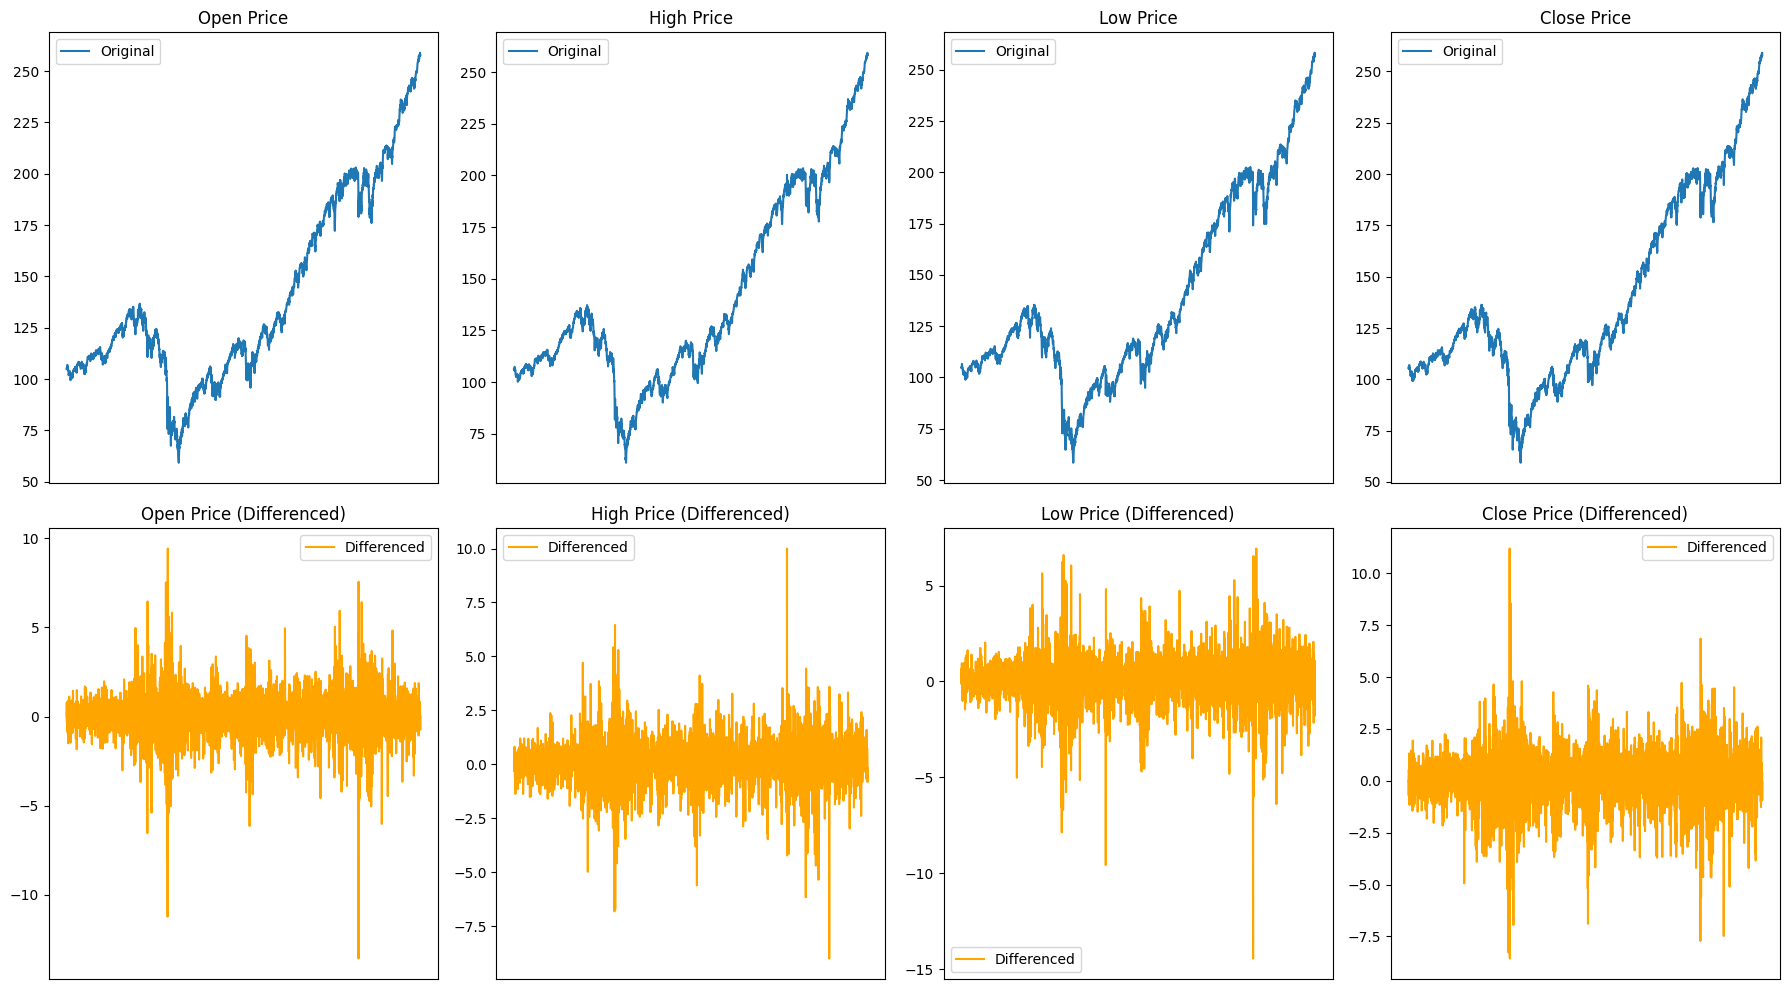

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10), sharex=True)

# 1. Extract unique years, handling 'yy-mm-dd' format
years_in_data = pd.to_datetime(sp500['Date'], format='%Y-%m-%d').dt.year.unique()

# 2. Create custom tick locations using years_in_data
tick_locations = [mdates.date2num(pd.to_datetime(f'{year}-01-01')) for year in years_in_data]
tick_labels = years_in_data.astype(str)

# 3. Iterate through subplots and apply custom ticks and labels
for i in range(4):
    axes[0, i].set_xticks(tick_locations)
    axes[0, i].set_xticklabels(tick_labels, rotation=45, ha='right')
    axes[1, i].set_xticks(tick_locations)
    axes[1, i].set_xticklabels(tick_labels, rotation=45, ha='right')

# Plot the data
price_types = ['Open', 'High','Low', 'Close']
for i, price_type in enumerate(price_types):
    # Plot original prices
    axes[0, i].plot(sp500['Date'], sp500[price_type], label='Original')
    axes[0, i].set_title(f'{price_type} Price')
    axes[0, i].legend()

    # Plot differenced prices
    axes[1, i].plot(sp500['Date'], sp500[f'{price_type}_diff'], label='Differenced', color='orange')
    axes[1, i].set_title(f'{price_type} Price (Differenced)')
    axes[1, i].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [32]:
# Redo check for stationarity using ADF test on differenced data
result = adfuller(sp500['Close_diff'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation:
# If p-value < 0.05, the series is stationary.

ADF Statistic: -12.489142144865175
p-value: 2.972267302768441e-23


According to the hypothesis test, there is strong evidence against the null so we reject the hypothesis that the data is not stationary. This is the desired outcome and now we start testing an ARIMA model to compare predicted and true volatility.

In [33]:
#note that we had to split data after the transformation because this is unlike normalisation
#we are now judging volatility which is completely different from the actual stock price
#split only last 5 years of data into training and testing
#use the opening and average differences as feature variables
#and closing differences as the target because we want to predict closing prices
#since they are considered the "latest" most current state of prices we have before
#the new day arrives
ex_factors=['Open_diff','High_diff','Low_diff']
sp500['Date'] = pd.to_datetime(sp500['Date'])
new_sp500=sp500[sp500['Date'].dt.year >= 2012]
sp500_train,sp500_test=split_data(new_sp500,0.8)
X_train,X_test=sp500_train[ex_factors],sp500_test[ex_factors]
y_train,y_test=sp500_train['Close_diff'],sp500_test['Close_diff']

In [34]:
from statsmodels.tsa.arima.model import ARIMA
from joblib import Parallel, delayed
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

In [52]:
from statsmodels.tsa.arima.model import ARIMA
from joblib import Parallel, delayed
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

def evaluate_arima_model(X_train, y_train, X_test, y_test, order, seasonal_order):
  """Fits an ARIMA model and returns predictions."""
  try:
    # Create and fit the ARIMA model on the training data
    model = ARIMA(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)  # Include seasonal_order
    model_fit = model.fit()

    # Make predictions on the testing data
    predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
    mse = mean_squared_error(y_test, predictions, squared=True)

    return order, seasonal_order, mse  # Return order, seasonal_order and MSE
  except Exception as e:
    print(f"Error with order {order}, seasonal_order {seasonal_order}: {e}")
    return None

def grid_search_arima_parallel(X_train, y_train, p_values, d_values, q_values, P_values, D_values, Q_values, s_values, n_jobs, n_splits):
    """
    Performs a grid search for ARIMA model hyperparameters using parallel computing.
    Includes seasonal parameters.
    """

    best_order = None
    best_seasonal_order = None
    best_mse = float('inf')
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Create a list of all hyperparameter combinations
    order_param_combinations = list(itertools.product(p_values, d_values, q_values))
    seasonal_order_param_combinations = list(itertools.product(P_values, D_values, Q_values, s_values))

    # Evaluate all model configurations in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_arima_model)(
            X_train.iloc[train_idx],
            y_train.iloc[train_idx],
            X_train.iloc[validate_idx],
            y_train.iloc[validate_idx],
            order,
            seasonal_order  # Include seasonal_order in function call
        )
        for order in order_param_combinations
        for seasonal_order in seasonal_order_param_combinations # Iterate through seasonal orders
        for train_idx, validate_idx in tscv.split(X_train)
    )

    # Filter out failed configurations and find the best model
    valid_results = [result for result in results if result is not None]
    if valid_results:
        best_order, best_seasonal_order, best_mse = min(valid_results, key=lambda x: x[2])

    return best_order, best_seasonal_order, best_mse

We use MSE as the quantifier for selecting the best parameter combination because we know that the magnitude of differences is less than 1 most of the time which could potentially lead of numerical instability issues.

In [ ]:
#cross validate
best_order,best_mse=grid_search_arima_parallel(
    X_train=X_train,
    y_train=y_train,
    p_values=range(4),
    d_values=range(4),
    q_values=range(4),
    P_values=range(4),
    D_values=range(4),
    Q_values=range(4),
    s_values=[4],
    n_jobs=-1,
    n_splits=3,
)

In [ ]:
print(best_order,best_seasonal_order)

RMSE: 0.5058401051451222
MAE: 0.38865626273883563
MSE: 0.2558742119732283


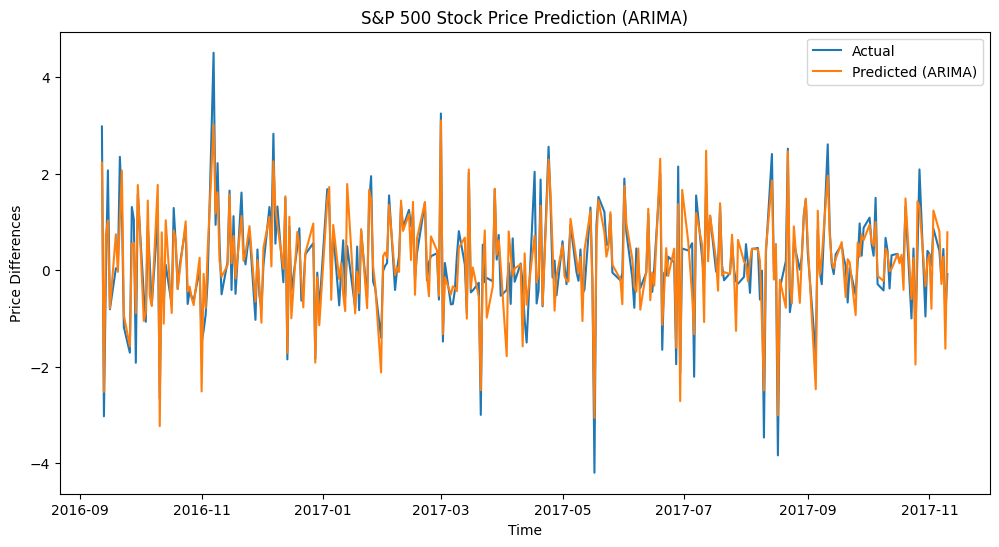

In [ ]:
model = ARIMA(y_train, exog=X_train, order=best_order,seasonal_order=best_seasonal_order) # Include exog for features
model_fit = model.fit()
# Make predictions on the testing data
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions

rmse = mean_squared_error(sp500_test['Close_diff'], predictions, squared=False)
mae = mean_absolute_error(sp500_test['Close_diff'], predictions)
mse = mean_squared_error(sp500_test['Close_diff'], predictions)
mape = mean_absolute_percentage_error(sp500_test['Close_diff'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
plt.figure(figsize=(12, 6))
plt.plot(sp500_test['Date'],sp500_test['Close_diff'], label='Actual')
plt.plot(sp500_test['Date'],predictions, label='Predicted (ARIMA)')
plt.title('S&P 500 Stock Price Prediction (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

Let's now reverse the volatility predicitons to the actual predicitons against the actual prices so it's easier to interpret the performance of our model.

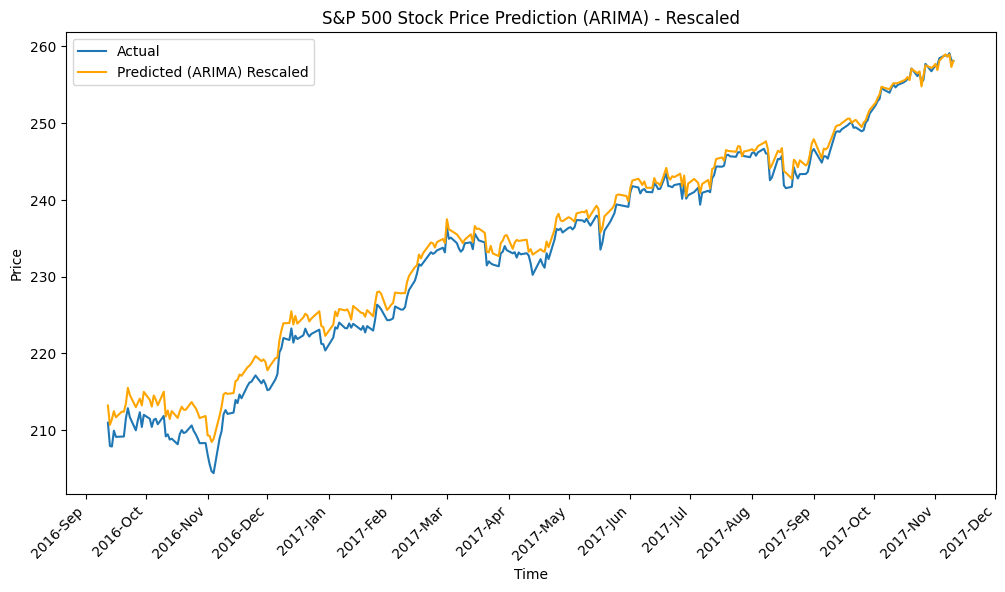

Rescaled RMSE: 1.775584312811923
Rescaled MAE: 1.5282300867723415
Rescaled MSE: 3.1526996519037893
Rescaled MAPE: 0.00680815101582312


In [ ]:
predictions_rescaled = sp500_test['Close'].iloc[0] + predictions.cumsum()

# Plot actual vs. rescaled predicted prices
plt.figure(figsize=(12, 6))
plt.plot(sp500_test['Date'], sp500_test['Close'], label='Actual')
plt.plot(sp500_test['Date'], predictions_rescaled, label='Predicted (ARIMA) Rescaled', color='orange')
plt.title('S&P 500 Stock Price Prediction (ARIMA) - Rescaled')
# Convert 'Date' column to datetime
sp500_test['Date'] = pd.to_datetime(sp500_test['Date'], format='%Y-%m-%d')

# Extract unique years and create tick locations/labels
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  # Format as 'Year-Month'
plt.xticks(rotation=45, ha='right')  # Rotate for readability

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate evaluation metrics on rescaled prices
rmse_rescaled = mean_squared_error(sp500_test['Close'], predictions_rescaled, squared=False)
mae_rescaled = mean_absolute_error(sp500_test['Close'], predictions_rescaled)
mse_rescaled = mean_squared_error(sp500_test['Close'], predictions_rescaled)
mape_rescaled = mean_absolute_percentage_error(sp500_test['Close'], predictions_rescaled)


# Print the evaluation metrics for rescaled predictions
print(f'Rescaled RMSE: {rmse_rescaled}')
print(f'Rescaled MAE: {mae_rescaled}')
print(f'Rescaled MSE: {mse_rescaled}')
print(f'Rescaled MAPE: {mape_rescaled}')

At a glance, the model performs well during most segments. We hypothesise that at sections where poorer performance is evident, this could be attributed to the model's inability to forecast unexpected differences that exceed the magnitude of those found in the training data. Particularly towards the start of the testing period, we see the predictions deviate more from the true price because the volatility pattern may not have been captured during training. Overall, this model performs at an average standard compared to our other models as it actually captures the non-linear patterns of the price quite well but does not excel at accurately doing so.

### (G)ARCH approach
The next model we wanted to explore was ARCH or AutoRegressive Conditional Heteroskedasticity. It is a well-known technique to use when modelling financial returns on an investment. An ARCH model is parameterised as follows:

Let  $y_t$  be a time series that is modeled as:

$$y_t = \mu + \epsilon_t$$

where:

$\mu$  is the mean,
$\epsilon_t$  is the error term, which represents the random changes at time t.

The error term  $\epsilon_t$  is assumed to have the following properties:

* $\epsilon_t$ = $\sigma_t z_t$
* $z_t$  is a white noise process with mean zero and variance 1, i.e.,  $z_t \sim N(0, 1)$ .
$\sigma_t^2$  is the conditional variance at time t.

The conditional variance is calculated as follows:

$\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \cdots + \alpha_q \epsilon_{t-q}^2$

where $\alpha_i$ is a positive weight placed on each term, $\epsilon_{t}$

The heteroskedacity property of the model (the ability to predict changes in error over time) allows for the measurement of volatility. A generalised ARCH adds the element of conditonal variance of the past error term to the model. This is particularly useful in our context because we are under the assumption that historical data (past prices) has a causal effect on predicted prices. It is VERY important to note that GARCH predicts the DIFFERENCE or change in stock prices, not the stock price itself.

However, after debugging failures, we chose not to explore it further. Instead some literature indicates the feasibility of autoregressive regression models on our data. See links below.

Investopedia. (2020). Generalized AutoRegressive Conditional Heteroskedasticity (GARCH) Definition. Investopedia. https://www.investopedia.com/terms/g/garch.asp
‌

Fryzlewicz, P. (2007). Lecture notes: Financial time series, ARCH and GARCH models. http://stats.lse.ac.uk/fryzlewicz/lec_notes/garch.pdf



## Testing on other stocks
Our hypothesis states that our model should be able to perform reasonably well on stocks contained in the S&P500 because the definition of the S&P500 ETF is that it measures the overall performance of the top 500 performing stocks in the market so intuitively, it could be a good measure of performance for a single stock contained in the rankings.

For our first test case, we choose Apple (aapl) which is known to be a dominant stock in the S&P500 and the tech industy. We want to avoid computationally expensive operations whenever possible which is why we avoid cross validation on the data and retain the same hyperparameters as those determined from cross-validating over the S&P500 ETF. The intuition behind this is that the hyperparameters determined from training on the ETF are essentially markers of an optimal model for the stocks within the S&P500.

In [ ]:
aapl=pd.read_csv('/content/drive/MyDrive/cs3244_data/Stocks/aapl.us.txt')
aapl.drop(columns={'OpenInt','Volume'}, inplace=True)
aapl=differencing_func(aapl)

We only consider last 5 years of data to maintain consistency. In addition, it is known that Apple has gone through very unexpected changes before this period of time. Hence, using our model on older data would not provide a fair comparison. (This is evident from the sudden behaviours and extreme price hikes experienced by Apple during the course of its history.)

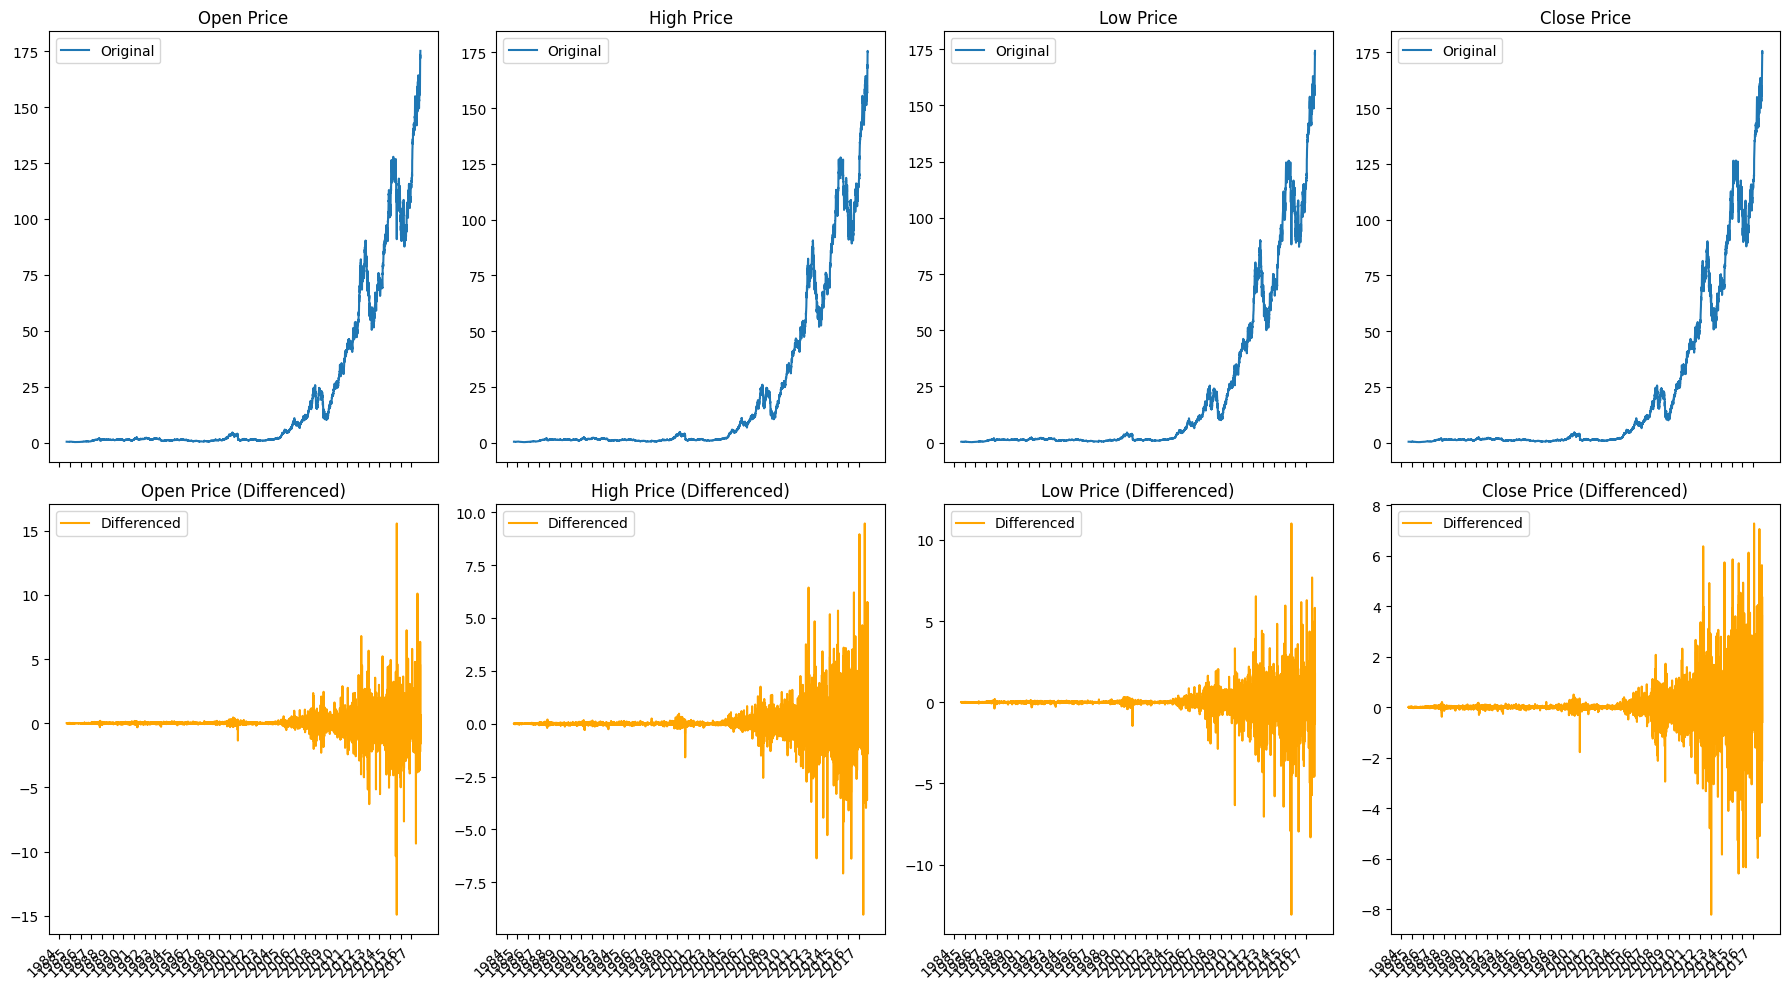

In [ ]:
# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 4, figsize=(18, 10), sharex=True)
years_in_data = pd.to_datetime(aapl['Date'], format='%Y-%m-%d').dt.year.unique()
aapl['Date'] = pd.to_datetime(aapl['Date'])
tick_locations = [mdates.date2num(pd.to_datetime(f'{year}-01-01')) for year in years_in_data]
tick_labels = years_in_data.astype(str)
# 3. Iterate through subplots and apply custom ticks and labels
for i in range(4):
    axes[0, i].set_xticks(tick_locations)
    axes[0, i].set_xticklabels(tick_labels, rotation=45, ha='right')
    axes[1, i].set_xticks(tick_locations)
    axes[1, i].set_xticklabels(tick_labels, rotation=45, ha='right')

price_type=['Open','High','Low','Close']

for i, price_type in enumerate(price_types):
    # Plot original prices
    axes[0, i].plot(aapl['Date'], aapl[price_type], label='Original')
    axes[0, i].set_title(f'{price_type} Price')
    axes[0, i].legend()

    # Plot differenced prices
    axes[1, i].plot(aapl['Date'], aapl[f'{price_type}_diff'], label='Differenced', color='orange')
    axes[1, i].set_title(f'{price_type} Price (Differenced)')
    axes[1, i].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
new_aapl=aapl[aapl['Date'].dt.year >= 2012]
aapl_train,aapl_test=split_data(new_aapl,0.8)
X_train,X_test=aapl_train[['Open_diff','High_diff','Low_diff']],aapl_test[['Open_diff','High_diff','Low_diff']]
y_train,y_test=aapl_train['Close_diff'],aapl_test['Close_diff']

We want to avoid computationally expensive operations and we have reiterated that the purpose of this project is to test models with the same hyperparameters on different sets of data. Hence, no cross validation will be performed.

RMSE: 0.6863127733542626
MAE: 0.5325991944197114
MSE: 0.4710252228692194


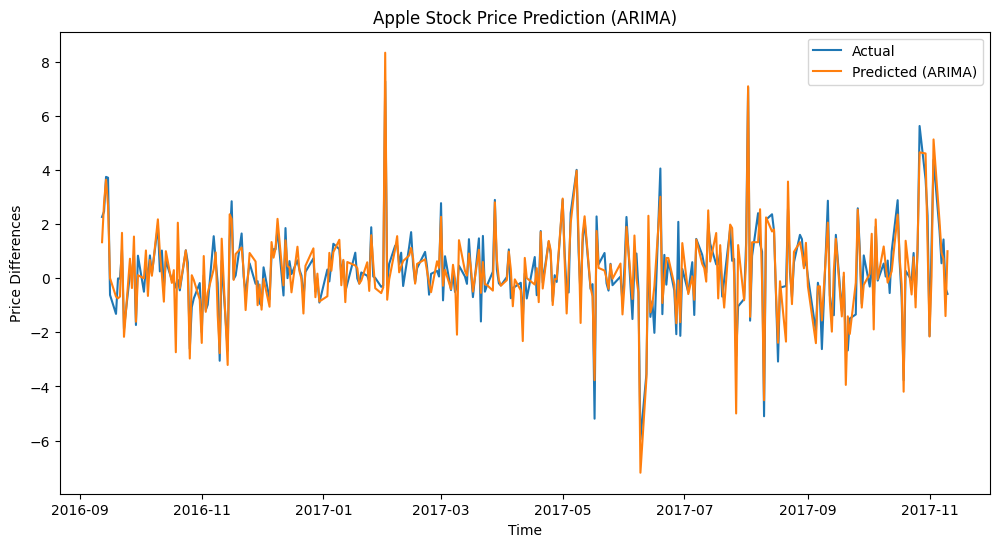

In [ ]:
model = ARIMA(y_train, exog=X_train, order=best_order,seasonal_order=best_seasonal_order) # Include exog for features
model_fit = model.fit()
# Make predictions on the testing data
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions

rmse = mean_squared_error(aapl_test['Close_diff'], predictions, squared=False)
mae = mean_absolute_error(aapl_test['Close_diff'], predictions)
mse = mean_squared_error(aapl_test['Close_diff'], predictions)
mape = mean_absolute_percentage_error(aapl_test['Close_diff'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
plt.figure(figsize=(12, 6))
plt.plot(aapl_test['Date'],aapl_test['Close_diff'], label='Actual')
plt.plot(aapl_test['Date'],predictions, label='Predicted (ARIMA)')
plt.title('Apple Stock Price Prediction (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

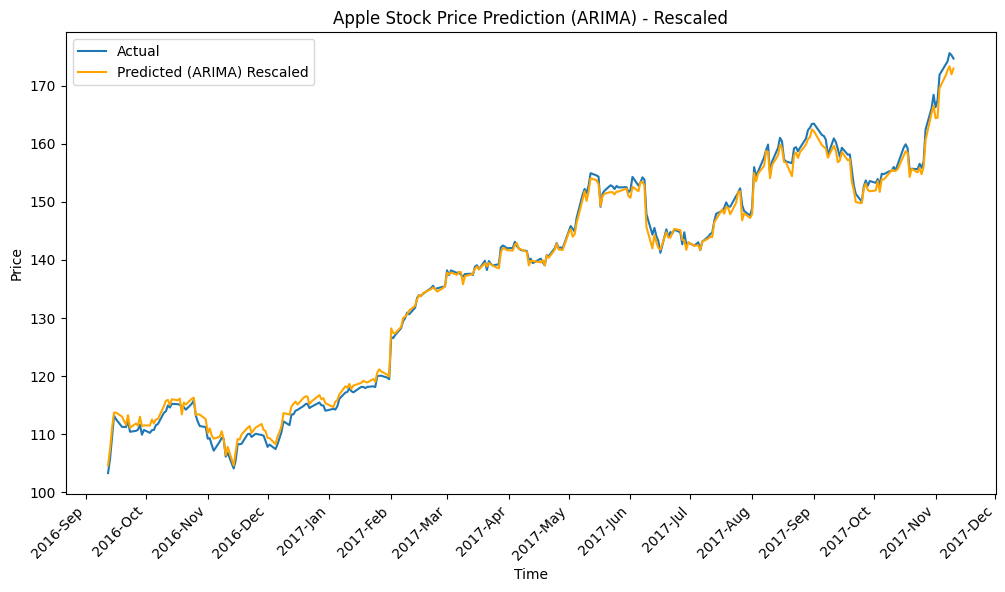

Rescaled RMSE: 1.0529107513931852
Rescaled MAE: 0.8744923039922614
Rescaled MSE: 1.108621050399362
Rescaled MAPE: 0.006565375341518237


In [ ]:
predictions_rescaled = aapl_test['Close'].iloc[0] + predictions.cumsum()

# Plot actual vs. rescaled predicted prices
plt.figure(figsize=(12, 6))
plt.plot(aapl_test['Date'], aapl_test['Close'], label='Actual')
plt.plot(aapl_test['Date'], predictions_rescaled, label='Predicted (ARIMA) Rescaled', color='orange')
plt.title('Apple Stock Price Prediction (ARIMA) - Rescaled')
# Convert 'Date' column to datetime
aapl_test['Date'] = pd.to_datetime(aapl_test['Date'], format='%Y-%m-%d')

# Extract unique years and create tick locations/labels
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  # Format as 'Year-Month'
plt.xticks(rotation=45, ha='right')  # Rotate for readability

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate evaluation metrics on rescaled prices
rmse_rescaled = mean_squared_error(aapl_test['Close'], predictions_rescaled, squared=False)
mae_rescaled = mean_absolute_error(aapl_test['Close'], predictions_rescaled)
mse_rescaled = mean_squared_error(aapl_test['Close'], predictions_rescaled)
mape_rescaled = mean_absolute_percentage_error(aapl_test['Close'], predictions_rescaled)


# Print the evaluation metrics for rescaled predictions
print(f'Rescaled RMSE: {rmse_rescaled}')
print(f'Rescaled MAE: {mae_rescaled}')
print(f'Rescaled MSE: {mse_rescaled}')
print(f'Rescaled MAPE: {mape_rescaled}')

We observe from the MAPE that our model does not predict accurately. Yet, from the magnitude of our other error metrics, it seems like our model performs better than it does on the S&P500 in terms of accuracy. We cannot yet verify that our model is effective because MSE and RMSE only measure magnitude of error without taking volatility into account.

Next, we verify the strength of our model through further testing on another dominant stock from a different industry with potentially different volatility behaviours. We select JP Morgan as the next stock, from the financial sector for further testing.

In [ ]:
jpm=pd.read_csv('/content/drive/MyDrive/cs3244_data/Stocks/jpm.us.txt')
jpm.drop(columns={'OpenInt','Volume'}, inplace=True)
jpm=differencing_func(jpm)

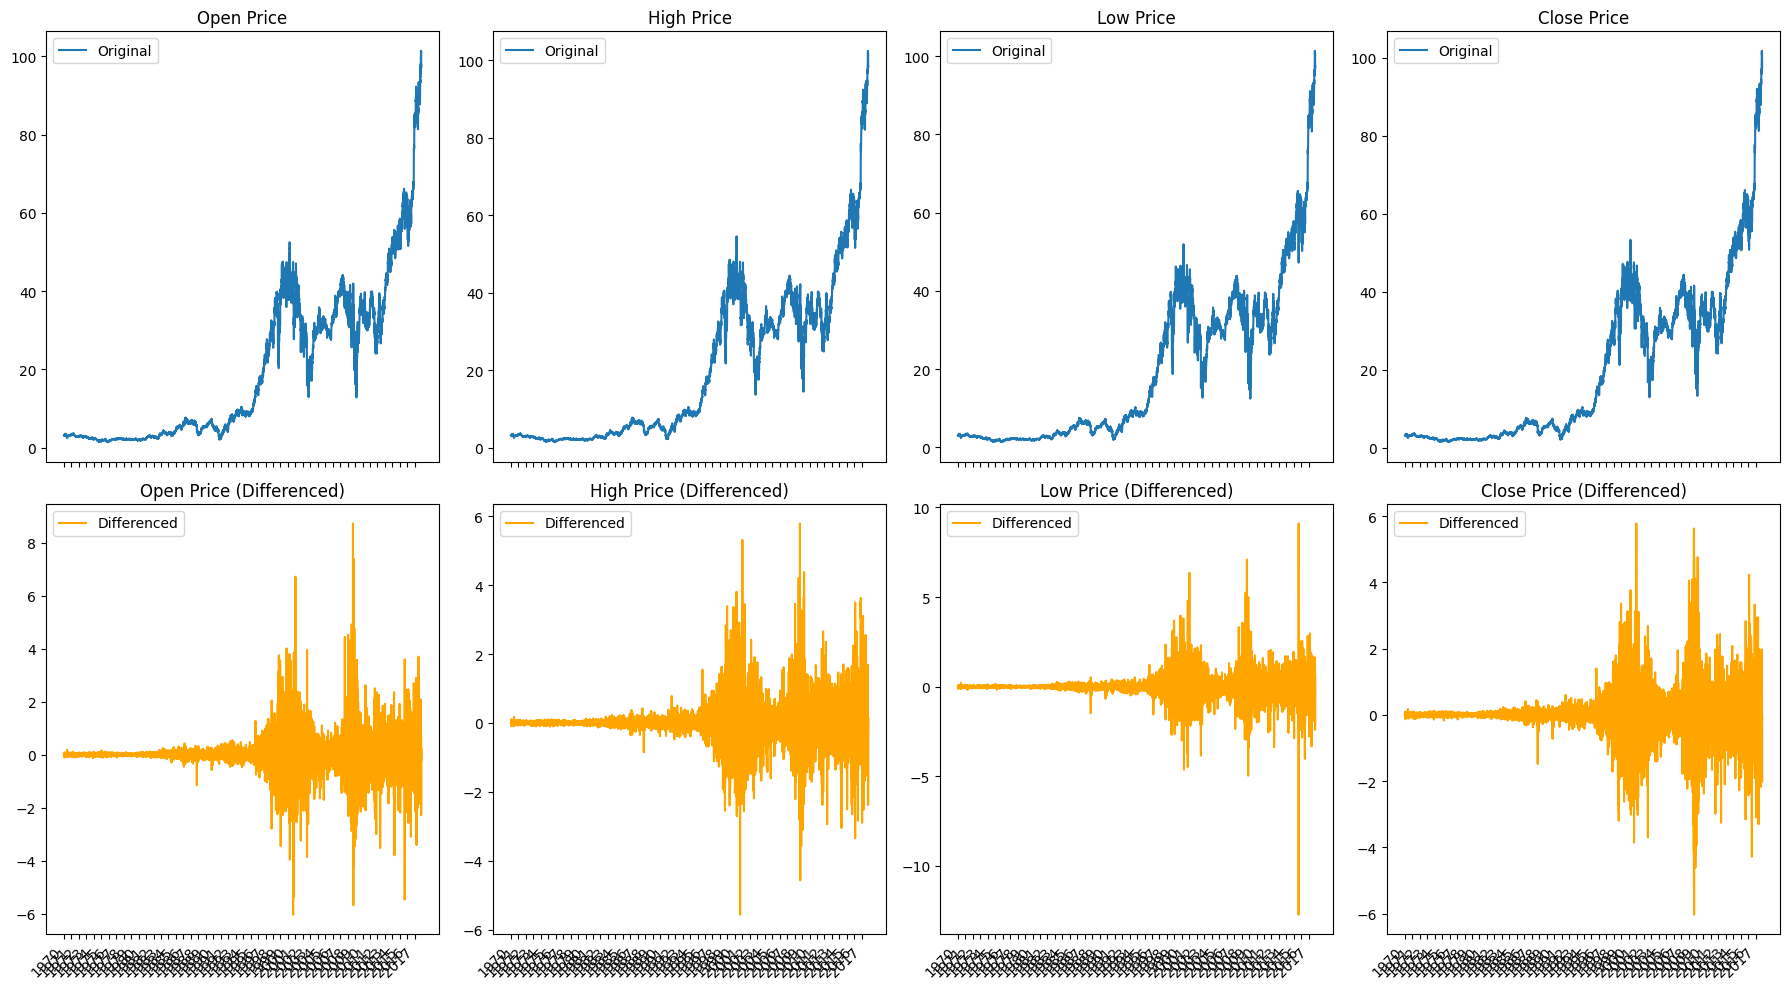

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10), sharex=True)
years_in_data = pd.to_datetime(jpm['Date'], format='%Y-%m-%d').dt.year.unique()
jpm['Date'] = pd.to_datetime(jpm['Date'])
tick_locations = [mdates.date2num(pd.to_datetime(f'{year}-01-01')) for year in years_in_data]
tick_labels = years_in_data.astype(str)
jpm['Date'] = pd.to_datetime(jpm['Date'])
# 3. Iterate through subplots and apply custom ticks and labels
for i in range(4):
    axes[0, i].set_xticks(tick_locations)
    axes[0, i].set_xticklabels(tick_labels, rotation=45, ha='right')
    axes[1, i].set_xticks(tick_locations)
    axes[1, i].set_xticklabels(tick_labels, rotation=45, ha='right')

# Plot the data
price_types = ['Open', 'High','Low','Close']
for i, price_type in enumerate(price_types):
    # Plot original prices
    axes[0, i].plot(jpm['Date'], jpm[price_type], label='Original')
    axes[0, i].set_title(f'{price_type} Price')
    axes[0, i].legend()

    # Plot differenced prices
    axes[1, i].plot(jpm['Date'], jpm[f'{price_type}_diff'], label='Differenced', color='orange')
    axes[1, i].set_title(f'{price_type} Price (Differenced)')
    axes[1, i].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
new_jpm=jpm[jpm['Date'].dt.year >= 2012]
jpm_train,jpm_test=split_data(new_jpm,0.8)
X_train,X_test=jpm_train[['Open_diff','High_diff','Low_diff']],jpm_test[['Open_diff','High_diff','Low_diff']]
y_train,y_test=jpm_train['Close_diff'],jpm_test['Close_diff']

RMSE: 0.4494707567849124
MAE: 0.34549109577566645
MSE: 0.20202396120480187


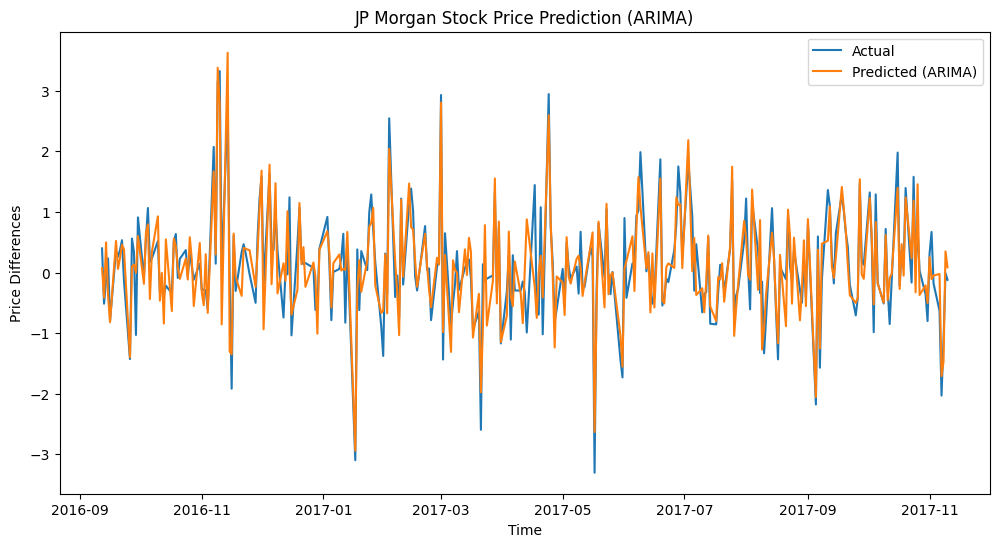

In [ ]:
model = ARIMA(y_train, exog=X_train, order=best_order,seasonal_order=best_seasonal_order) # Include exog for features
model_fit = model.fit()
# Make predictions on the testing data
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions

rmse = mean_squared_error(jpm_test['Close_diff'], predictions, squared=False)
mae = mean_absolute_error(jpm_test['Close_diff'], predictions)
mse = mean_squared_error(jpm_test['Close_diff'], predictions)
mape = mean_absolute_percentage_error(jpm_test['Close_diff'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
plt.figure(figsize=(12, 6))
plt.plot(jpm_test['Date'],jpm_test['Close_diff'], label='Actual')
plt.plot(jpm_test['Date'],predictions, label='Predicted (ARIMA)')
plt.title('JP Morgan Stock Price Prediction (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

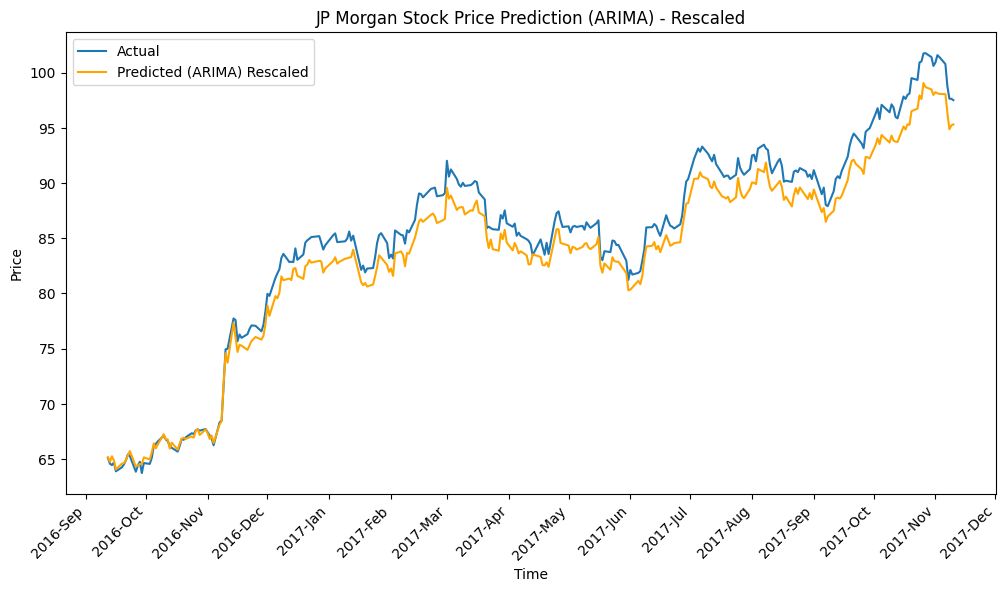

Rescaled RMSE: 1.8375073273962599
Rescaled MAE: 1.6619433627895954
Rescaled MSE: 3.376433178234946
Rescaled MAPE: 0.018795227924334065


In [ ]:
predictions_rescaled = jpm_test['Close'].iloc[0] + predictions.cumsum()

# Plot actual vs. rescaled predicted prices
plt.figure(figsize=(12, 6))
plt.plot(jpm_test['Date'], jpm_test['Close'], label='Actual')
plt.plot(jpm_test['Date'], predictions_rescaled, label='Predicted (ARIMA) Rescaled', color='orange')
plt.title('JP Morgan Stock Price Prediction (ARIMA) - Rescaled')
# Convert 'Date' column to datetime
jpm_test['Date'] = pd.to_datetime(jpm_test['Date'], format='%Y-%m-%d')

# Extract unique years and create tick locations/labels
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  # Format as 'Year-Month'
plt.xticks(rotation=45, ha='right')  # Rotate for readability

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate evaluation metrics on rescaled prices
rmse_rescaled = mean_squared_error(jpm_test['Close'], predictions_rescaled, squared=False)
mae_rescaled = mean_absolute_error(jpm_test['Close'], predictions_rescaled)
mse_rescaled = mean_squared_error(jpm_test['Close'], predictions_rescaled)
mape_rescaled = mean_absolute_percentage_error(jpm_test['Close'], predictions_rescaled)


# Print the evaluation metrics for rescaled predictions
print(f'Rescaled RMSE: {rmse_rescaled}')
print(f'Rescaled MAE: {mae_rescaled}')
print(f'Rescaled MSE: {mse_rescaled}')
print(f'Rescaled MAPE: {mape_rescaled}')

Our model performs reasonably well too on the JP Morgan stock (although worse than Apple). We are starting to gain more evidence that indeed our model is beginning to generalise well on dominant stocks in the S&P500 when only being cross-validated on S&P500. Let's try the same procedure on Amazon, another dominant stock from a different sector from the previously explored stocks.

In [ ]:
amzn=pd.read_csv('/content/drive/MyDrive/cs3244_data/Stocks/amzn.us.txt')
amzn.drop(columns={'OpenInt','Volume'}, inplace=True)
amzn=differencing_func(amzn)

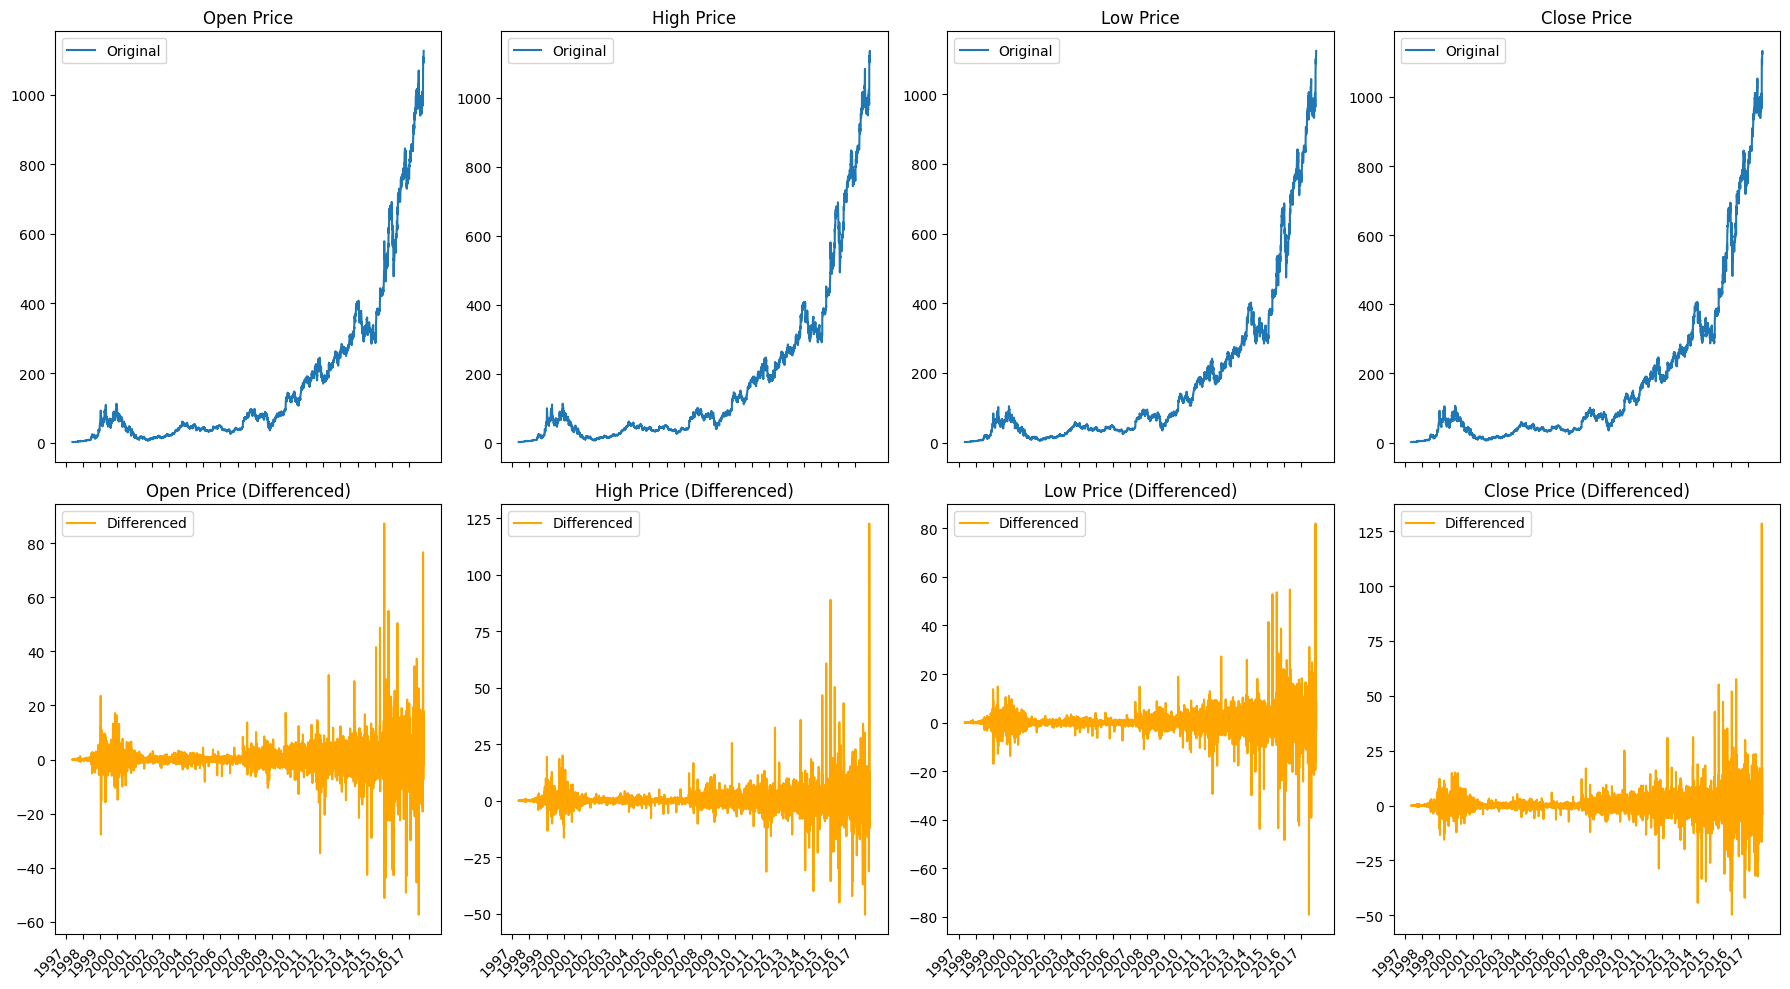

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10), sharex=True)
years_in_data = pd.to_datetime(amzn['Date'], format='%Y-%m-%d').dt.year.unique()
amzn['Date'] = pd.to_datetime(amzn['Date'])
tick_locations = [mdates.date2num(pd.to_datetime(f'{year}-01-01')) for year in years_in_data]
tick_labels = years_in_data.astype(str)
amzn['Date'] = pd.to_datetime(amzn['Date'])
# 3. Iterate through subplots and apply custom ticks and labels
for i in range(4):
    axes[0, i].set_xticks(tick_locations)
    axes[0, i].set_xticklabels(tick_labels, rotation=45, ha='right')
    axes[1, i].set_xticks(tick_locations)
    axes[1, i].set_xticklabels(tick_labels, rotation=45, ha='right')

# Plot the data
price_types = ['Open', 'High','Low','Close']
for i, price_type in enumerate(price_types):
    # Plot original prices
    axes[0, i].plot(amzn['Date'], amzn[price_type], label='Original')
    axes[0, i].set_title(f'{price_type} Price')
    axes[0, i].legend()

    # Plot differenced prices
    axes[1, i].plot(amzn['Date'], amzn[f'{price_type}_diff'], label='Differenced', color='orange')
    axes[1, i].set_title(f'{price_type} Price (Differenced)')
    axes[1, i].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
new_amzn=amzn[amzn['Date'].dt.year >= 2012]
amzn_train,amzn_test=split_data(new_amzn,0.8)
X_train,X_test=amzn_train[['Open_diff','High_diff','Low_diff']],amzn_test[['Open_diff','High_diff','Low_diff']]
y_train,y_test=amzn_train['Close_diff'],amzn_test['Close_diff']

RMSE: 5.108998785932953
MAE: 3.6717033989909345
MSE: 26.101868594664385


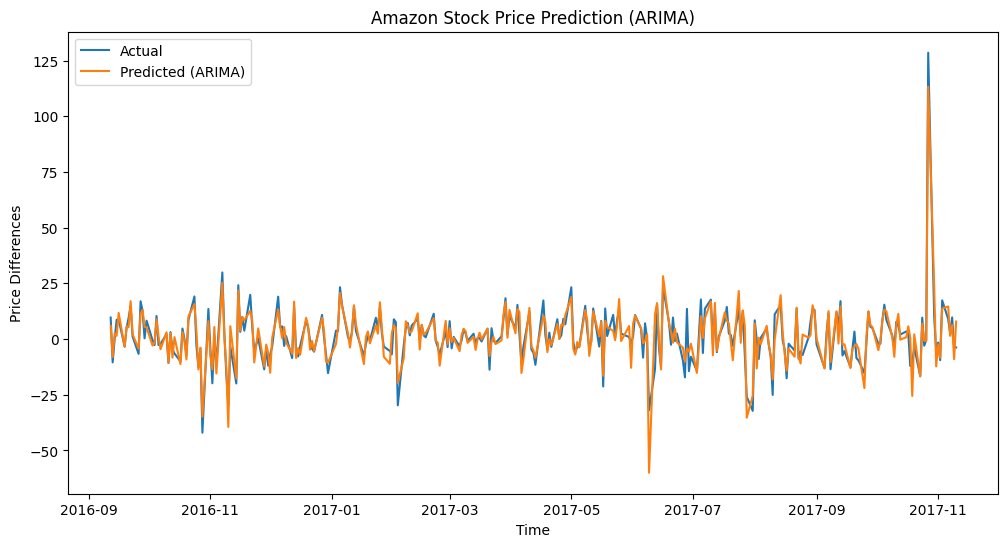

In [ ]:
model = ARIMA(y_train, exog=X_train, order=best_order,seasonal_order=best_seasonal_order) # Include exog for features
model_fit = model.fit()
# Make predictions on the testing data
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)  # Include exog for predictions

rmse = mean_squared_error(amzn_test['Close_diff'], predictions, squared=False)
mae = mean_absolute_error(amzn_test['Close_diff'], predictions)
mse = mean_squared_error(amzn_test['Close_diff'], predictions)
mape = mean_absolute_percentage_error(amzn_test['Close_diff'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
plt.figure(figsize=(12, 6))
plt.plot(amzn_test['Date'],amzn_test['Close_diff'], label='Actual')
plt.plot(amzn_test['Date'],predictions, label='Predicted (ARIMA)')
plt.title('Amazon Stock Price Prediction (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Price Differences')
plt.legend()
plt.show()

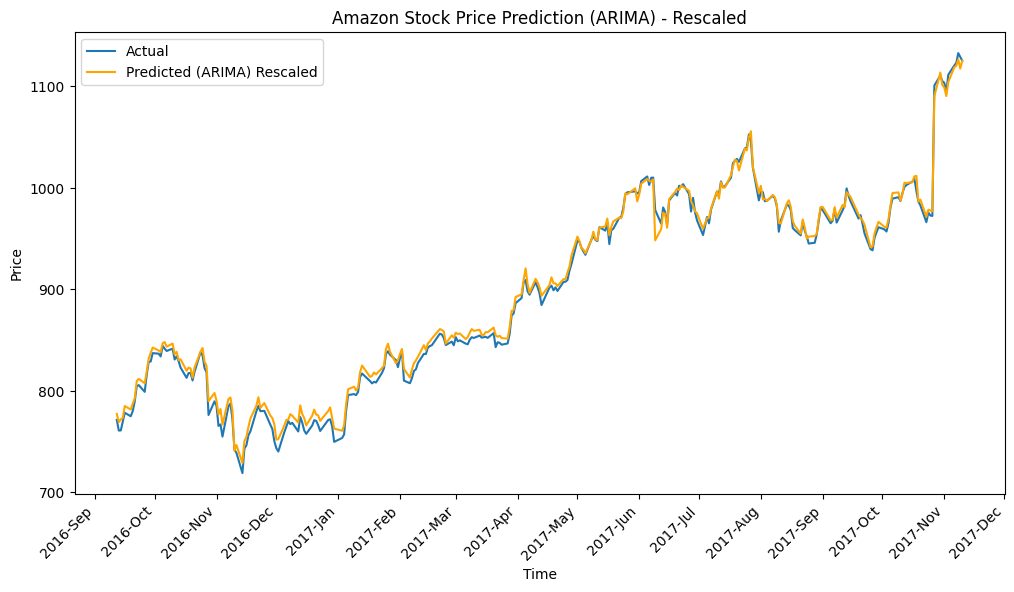

Rescaled RMSE: 6.293012983219053
Rescaled MAE: 5.227037624922525
Rescaled MSE: 39.60201240696356
Rescaled MAPE: 0.006087061595530926


In [ ]:
predictions_rescaled = amzn_test['Close'].iloc[0] + predictions.cumsum()

# Plot actual vs. rescaled predicted prices
plt.figure(figsize=(12, 6))
plt.plot(amzn_test['Date'], amzn_test['Close'], label='Actual')
plt.plot(amzn_test['Date'], predictions_rescaled, label='Predicted (ARIMA) Rescaled', color='orange')
plt.title('Amazon Stock Price Prediction (ARIMA) - Rescaled')
# Convert 'Date' column to datetime
amzn_test['Date'] = pd.to_datetime(amzn_test['Date'], format='%Y-%m-%d')

# Extract unique years and create tick locations/labels
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  # Format as 'Year-Month'
plt.xticks(rotation=45, ha='right')  # Rotate for readability

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate evaluation metrics on rescaled prices
rmse_rescaled = mean_squared_error(amzn_test['Close'], predictions_rescaled, squared=False)
mae_rescaled = mean_absolute_error(amzn_test['Close'], predictions_rescaled)
mse_rescaled = mean_squared_error(amzn_test['Close'], predictions_rescaled)
mape_rescaled = mean_absolute_percentage_error(amzn_test['Close'], predictions_rescaled)


# Print the evaluation metrics for rescaled predictions
print(f'Rescaled RMSE: {rmse_rescaled}')
print(f'Rescaled MAE: {mae_rescaled}')
print(f'Rescaled MSE: {mse_rescaled}')
print(f'Rescaled MAPE: {mape_rescaled}')

We begin to see significantly worse performance on this stock. Thus, this is sufficient evidence against our hypothesis that a model trained on S&P500 data cannot generalise with extreme accuracy on other stocks contained within the ETF all the time. Potential modifications that may result in better performing models include changing the cross-validation strategy. Instead of measuring metrics of differenced data, metrics from rescaled data could be compared. Otherwise, cross validating separately on different stocks' data would likely produce better results.